In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib  # For saving and loading the model
from scipy.stats import chisquare
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import pearsonr

In [2]:
# Read the manipulated dataset
filename_T = "mtcars_manipulated.csv" #Manipulated data from Tuvshin
filename_M = "My_mpg_manipulated.csv" #My manipulated data
filename_O = "mtcars_original.csv" #Original data

dfT = pd.read_csv(filename_T)
dfM = pd.read_csv(filename_M)
dfO = pd.read_csv(filename_O)

# Select only relavant variables
X_T = dfT[['mpg', 'hp', 'wt']] #From Tuvshin manipulated data
X_M = dfM[['mpg', 'hp', 'wt']] #From my manipulated data
X_O = dfO[['mpg', 'hp', 'wt']] #From original data


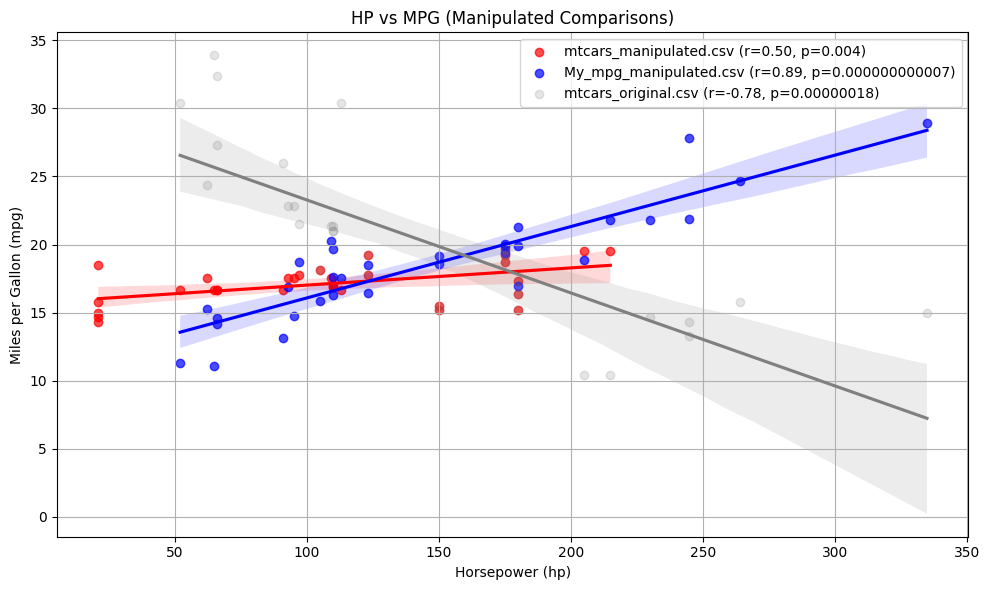

In [3]:
# Compute correlation and p-value
r_t, p_t = pearsonr(dfT['hp'], dfT['mpg'])
r_m, p_m = pearsonr(dfM['hp'], dfM['mpg'])
r_o, p_o = pearsonr(dfO['hp'], dfO['mpg'])

# Plot
plt.figure(figsize=(10, 6))
sns.regplot(x='hp', y='mpg', data=dfT, label=f"{filename_T} (r={r_t:.2f}, p={p_t:.3f})", color='red', scatter_kws={'alpha':0.7})
sns.regplot(x='hp', y='mpg', data=dfM, label=f"{filename_M} (r={r_m:.2f}, p={p_m:.12f})", color='blue', scatter_kws={'alpha':0.7})
sns.regplot(x='hp', y='mpg', data=dfO, label=f"{filename_O} (r={r_o:.2f}, p={p_o:.8f})", color='gray', scatter_kws={'alpha':0.2})

plt.title('HP vs MPG (Manipulated Comparisons)')
plt.xlabel('Horsepower (hp)')
plt.ylabel('Miles per Gallon (mpg)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [4]:
# Random Forest Classifier
# -----------------------------

# Load trained RandomForest model
# -----------------------------
# Load a pre-trained Random Forest Model
model = joblib.load("myRFmodel.pkl")

# -----------------------------
# Classify using loaded model
# -----------------------------
classifiedT = model.predict(X_T)
classifiedM = model.predict(X_M)
classifiedO = model.predict(X_O)

# -----------------------------
# Decide if the predicted is manipulated by majority
# -----------------------------
threshold = 0.5  
print("=== Random Forest Classification ===")

color = "\033[1;31m"

manipulated_ratioT = np.mean(classifiedT)

if manipulated_ratioT >= threshold:
    dataset_classificationT = "Manipulated"
else:
    dataset_classificationT = "Not Manipulated"
print(f"{color}{filename_T} classified as: {dataset_classificationT}\033[0m")
    
manipulated_ratioM = np.mean(classifiedM)

if manipulated_ratioM >= threshold:
    dataset_classificationM = "Manipulated"
else:
    dataset_classificationM = "Not Manipulated"

print(f"{color}{filename_M} classified as: {dataset_classificationM}\033[0m")
    
manipulated_ratioO = np.mean(classifiedO)
if manipulated_ratioO >= threshold:
    dataset_classificationO = "Manipulated"
else:
    dataset_classificationO = "Not Manipulated"
print(f"{filename_O} classified as: {dataset_classificationO}")



=== Random Forest Classification ===
mtcars_manipulated.csv classified as: Manipulated
My_mpg_manipulated.csv classified as: Manipulated
mtcars_original.csv classified as: Not Manipulated


In [5]:
#Benford functions

def benford_expected_distribution():
    return np.array([np.log10(1 + 1/d) for d in range(1, 10)])

def extract_first_digit(series):
    return (
        series.dropna()
        .astype(str)
        .str.replace(".", "", regex=False)
        .str.extract(r'([1-9])')[0]
        .dropna()
        .astype(int)
    )

def perform_benford_test(series):
    first_digits = extract_first_digit(series)
    observed_counts = first_digits.value_counts().sort_index()
    observed = observed_counts.reindex(range(1, 10), fill_value=0).values
    expected = benford_expected_distribution() * observed.sum()
    chi2, p = chisquare(f_obs=observed, f_exp=expected)
    return chi2, p

In [6]:
#Benford Classifier 

variable = 'mpg'
chi2_statT, p_valueT = perform_benford_test(X_T[variable])
chi2_statM, p_valueM = perform_benford_test(X_M[variable])
chi2_statO, p_valueO = perform_benford_test(X_O[variable])
# -----------------------------
# Classify dataset:  Find extreme manipulations
#  30.58	≈ 0.0001	Detects only the most extreme manipulations
# -----------------------------
if chi2_statT > 30.58 and p_valueT < 0.0001:
    classificationT = "Manipulated"
else:
    classificationM = "Not Manipulated"

if chi2_statM > 30.58 and p_valueM < 0.0001:
    classificationM = "Manipulated"
else:
    classificationM = "Not Manipulated"
    
if chi2_statO > 30.58 and p_valueO < 0.0001:
    classificationO = "Manipulated"
else:
    classificationO = "Not Manipulated"

# -----------------------------
# Output results
# -----------------------------
print("=== Benford Classification ===")
print(f"Variable analyzed: {variable}")
print(f"{color}{filename_T}Classified as: {classificationM}\033[0m")
print(f"{color}{filename_M}Classified as: {classificationM}\033[0m")
print(f"{filename_O} Classified as: {classificationO}")

=== Benford Classification ===
Variable analyzed: mpg
mtcars_manipulated.csvClassified as: Manipulated
My_mpg_manipulated.csvClassified as: Manipulated
mtcars_original.csv Classified as: Not Manipulated
